In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.nn import functional as F
import numpy as np
from sklearn.metrics import classification_report

## Import Dataset

In [3]:
# load mnist dataset for training
mnist_data_train = datasets.MNIST(
    '../data', 
    train=True, 
    download=True, 
    transform=transforms.ToTensor(),
)

# use data loader to load data in batches and shuffle the data so that the model does not overfit
trainloader = torch.utils.data.DataLoader(
    mnist_data_train, 
    batch_size=64, 
    shuffle=True
)

# get some random training images
dataiter = iter(trainloader)

# get one batch of training images
images, labels = next(dataiter)


In [4]:
PLUCKED_IMG = images[0]
PLUCKED_LABEL = labels[0].item()

Image shape: torch.Size([1, 28, 28])
Label: 8


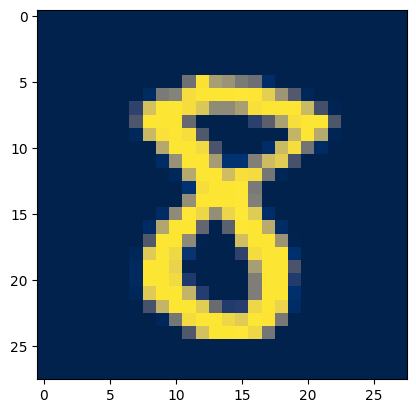

In [5]:
print(f"Image shape: {PLUCKED_IMG.shape}")

# visualize the first image
import matplotlib.pyplot as plt
plt.imshow(PLUCKED_IMG.numpy().squeeze(), cmap='cividis')
print(f"Label: {PLUCKED_LABEL}")

## Define Model

In [6]:
# define the model
class MulticlassLogisticRegression(nn.Module):
    def __init__(
            self, 
            input_dim, 
            output_dim
        ):
        
        super(MulticlassLogisticRegression, self).__init__()

        # layers:
        # 1. input layer (28 * 28 = 784 neurons)
        # 2. output layer (10 neurons)
        # no hidden layers
        self.linear = nn.Linear(input_dim, output_dim)

    # define how the model is run from input to output
    def forward(self, x: torch.Tensor):

        # reshape the input tensor to a 1D tensor to match the input dimension
        # of the linear layer
        x = x.reshape(-1, 28*28) # NOTE_1

        # calculate the weighted sum and apply the softmax activation function
        out = self.linear(x)
        return out

NOTE_1 = """
x.reshape(-1, x): -1 is used to infer the shape of the first dimension based on
the size of the second dimension and the number of elements in the tensor in
this case, -1 will be inferred as 1, because the second dimension has 28*28=784
elements and the number of elements in the tensor is 784
"""
print(f"{NOTE_1}\nReshaped: {PLUCKED_IMG.reshape(-1, 28*28).shape}")


x.reshape(-1, x): -1 is used to infer the shape of the first dimension based on
the size of the second dimension and the number of elements in the tensor in
this case, -1 will be inferred as 1, because the second dimension has 28*28=784
elements and the number of elements in the tensor is 784

Reshaped: torch.Size([1, 784])


In [7]:
# create an instance of the model 
simple_nn = MulticlassLogisticRegression(
    input_dim=28*28,
    output_dim=10
)
print(simple_nn)

MulticlassLogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


## Model Training

In [8]:
# define the loss function with the softmax activation function to normalize the
# output from 0 to 1 (probabilities)
loss_function = nn.CrossEntropyLoss()

# set up the optimizer
optimizer = torch.optim.SGD(
    simple_nn.parameters(), 
    lr=0.01 # learning rate overshoots at some point
) 


running_loss = 0.0

for epoch in range(5): # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = simple_nn(inputs) # forward pass
        loss = loss_function(outputs, labels)
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[epoch {epoch + 1}, batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
        # calculate the gradients
        loss.backward() # backward pass
        optimizer.step()

[epoch 1, batch 100] loss: 1.892
[epoch 1, batch 200] loss: 1.360
[epoch 1, batch 300] loss: 1.086
[epoch 1, batch 400] loss: 0.939
[epoch 1, batch 500] loss: 0.852
[epoch 1, batch 600] loss: 0.774
[epoch 1, batch 700] loss: 0.717
[epoch 1, batch 800] loss: 0.691
[epoch 1, batch 900] loss: 0.642
[epoch 2, batch 100] loss: 0.597
[epoch 2, batch 200] loss: 0.588
[epoch 2, batch 300] loss: 0.579
[epoch 2, batch 400] loss: 0.576
[epoch 2, batch 500] loss: 0.544
[epoch 2, batch 600] loss: 0.546
[epoch 2, batch 700] loss: 0.537
[epoch 2, batch 800] loss: 0.517
[epoch 2, batch 900] loss: 0.501
[epoch 3, batch 100] loss: 0.496
[epoch 3, batch 200] loss: 0.501
[epoch 3, batch 300] loss: 0.489
[epoch 3, batch 400] loss: 0.468
[epoch 3, batch 500] loss: 0.461
[epoch 3, batch 600] loss: 0.480
[epoch 3, batch 700] loss: 0.467
[epoch 3, batch 800] loss: 0.461
[epoch 3, batch 900] loss: 0.434
[epoch 4, batch 100] loss: 0.454
[epoch 4, batch 200] loss: 0.442
[epoch 4, batch 300] loss: 0.442
[epoch 4, 

## Visualize Weights

Label: 8


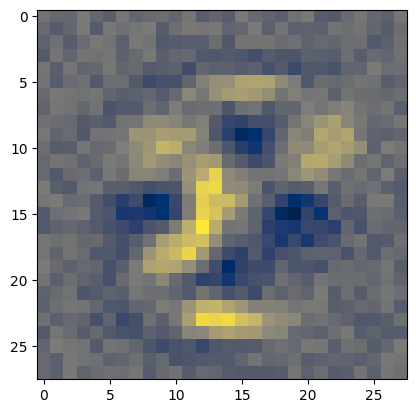

In [9]:
# visualize the weights of the model for the PLUCKED_LABEL
weights = simple_nn.linear.weight[PLUCKED_LABEL].detach().numpy()
plt.imshow(weights.reshape(28, 28), cmap='cividis')
print(f"Label: {PLUCKED_LABEL}")

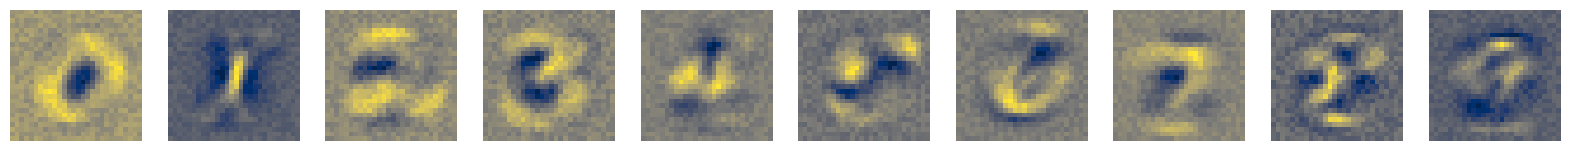

In [10]:
# visualize the weights of the model
weights = simple_nn.linear.weight.detach().numpy()
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axs[i].imshow(weights[i].reshape(28, 28), cmap='cividis')
    axs[i].axis('off')


## Evaluation

In [14]:
# load the test dataset
mnist_data_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(mnist_data_test, batch_size=64, shuffle=False)

# test the model
correct = 0
total = 0
predictions = []
ground_truth = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = simple_nn(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())
        ground_truth.extend(labels.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 90.03%


Text(95.72222222222221, 0.5, 'Actual')

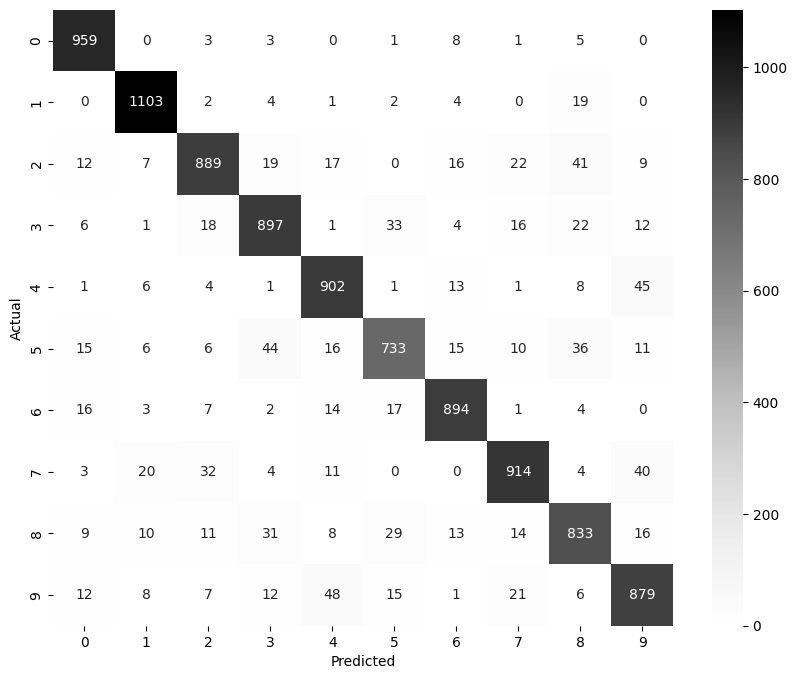

In [15]:
# create a confusion matrix
confusion_matrix = np.zeros((10, 10))
for i in range(len(predictions)):
    confusion_matrix[ground_truth[i]][predictions[i]] += 1

# visualize the confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('Actual')



In [16]:
# summary statistics with precision, recall, f1-score, and support
print(classification_report(ground_truth, predictions))

# TP         = True Positive, 
# FP         = False Positive
# FN         = False Negative
# precision  = TP / (TP + FP)
# recall     = TP / (TP + FN)
# f1-score   = 2 * (precision * recall) / (precision + recall)
# support    = number of occurrences of each class in the dataset


              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.91      0.86      0.88      1032
           3       0.88      0.89      0.89      1010
           4       0.89      0.92      0.90       982
           5       0.88      0.82      0.85       892
           6       0.92      0.93      0.93       958
           7       0.91      0.89      0.90      1028
           8       0.85      0.86      0.85       974
           9       0.87      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



[source tutorial](https://www.youtube.com/watch?v=ZAhxDgF5nNo&list=PLkguTFqZ9THEFEXP2BwgOA4twYZEqzflx)